#### Generate learning curves for 4v3 Keepaway

In [1]:
from GAME.utils.config import config
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from GAME.utils.helper_funcs import generate_keepaway_learning_curves

config_data = config()

In [25]:
def generate_keepaway_learning_curves(kwy_paths:list, window_size:int=900, alpha:float=0.01, coarse:int=30) -> tuple:
    """
    Description:
        Graphs keepaway learning curves using .kwy log files.

    Arguments:
        kwy_paths: a list of paths to the .kwy files. Used to splice together separate .kwy files.
        window_size: the size of the sliding window for averaging the number of steps.
        alpha: alpha value used in the low-pass filter to smooth the curve.
        coarse: every coarse-th point gets outputted to cut down on file size.

    Return:
        (tuple) a list of the training time and a list of the average episode durations.
    """
    # init variables
    ep_dur_sum = 0 # Window sum of episode durations
    start = 0
    q = np.zeros(shape = (1, window_size))
    output_X = []
    output_Y = []
    output_eps = []

    # read the first kwy file. There might be more that results from interrupted training
    initial_kwy_file_path = kwy_paths[0]

    # read the first window_size entries
    with open(initial_kwy_file_path, 'r') as f:
        # ignore header
        line = f.readline()
        while line[0] == '#':
            line = f.readline()
        # fill window
        for i in range(len(q[0])):
            if line: # while we still have non-empty lines
                parsed_line = line.split()
                ep_dur = int(parsed_line[3])
                q[0][i] = ep_dur
                ep_dur_sum += q[0][i]
                line = f.readline()
            else:
                raise ValueError("Not enough data to fill window.")

        # read the rest of the data
        i = 0
        ep = 0
        start = 0
        ccount = 0
        prev = ep_dur_sum
        while line:
            if ccount % coarse == 0:
                output_X.append(start / 10.0 / 3600)
                output_Y.append(prev / 10.0 / window_size)
                output_eps.append(ep)
            
            ep_dur_sum -= q[0][i]
            parsed_line = line.split()
            ep_dur = int(parsed_line[3])
            q[0][i] = ep_dur
            ep_dur_sum += q[0][i]
            start += q[0][i]

            prev = (1 - alpha) * prev + alpha * ep_dur_sum
            i = (i + 1) % window_size
            ccount += 1
            line = f.readline()

            ep += 1
    
    # continue to parse keepaway files if more are supplied. Appends this data to the previously computed data
    if len(kwy_paths) > 1:
        for kwy_path_idx in range(1, len(kwy_paths)):
            with open(kwy_paths[kwy_path_idx], 'r') as f:
                # ignore header
                line = f.readline()
                while line[0] == '#':
                    line = f.readline()

                # read the rest of the data
                while line:
                    if ccount % coarse == 0:
                        output_X.append(start / 10.0 / 3600)
                        output_Y.append(prev / 10.0 / window_size)
                        output_eps.append(ep)
                    
                    ep_dur_sum -= q[0][i]
                    parsed_line = line.split()
                    ep_dur = int(parsed_line[3])
                    q[0][i] = ep_dur
                    ep_dur_sum += q[0][i]
                    start += q[0][i]

                    prev = (1 - alpha) * prev + alpha * ep_dur_sum
                    i = (i + 1) % window_size
                    ccount += 1
                    line = f.readline()
                    
                    ep += 1
    
    # return the parsed kwy data
    return output_X, output_Y, output_eps

In [2]:
MC3D_train_folder_path = os.path.join(config_data['logs_path'], 'keepaway_4v3_p1', 'logs')
MC3D_train_filepath = os.path.join(MC3D_train_folder_path, '202211111729-UbuntuXenial.kwy')

In [32]:
MC3D_train_folder_path = os.path.join(config_data['logs_path'], 'initial_3v2_training_11052022')
MC3D_train_filepath = os.path.join(MC3D_train_folder_path, '202211031646-UbuntuXenial.kwy')

In [15]:
MC3D_train_folder_path = os.path.join(config_data['logs_path'], '4v3_hand_coded_mapping_results')
MC3D_train_filepath = os.path.join(MC3D_train_folder_path, '202211162250-UbuntuXenial.kwy')

In [32]:
MC3D_train_folder_path = os.path.join(config_data['logs_path'], '20221222 testing out combining two kwy files')
MC3D_logs = [os.path.join(MC3D_train_folder_path, '202212181836-UbuntuXenial.kwy'), os.path.join(MC3D_train_folder_path, '202212182048-UbuntuXenial.kwy')]

In [33]:
output_X, output_Y, output_eps = generate_keepaway_learning_curves(MC3D_logs, 900, 0.01, 30)

In [6]:
avg_output_X = output_X[0]
output_Y = np.array(output_Y)
avg_output_Y = output_Y.mean(axis=0)

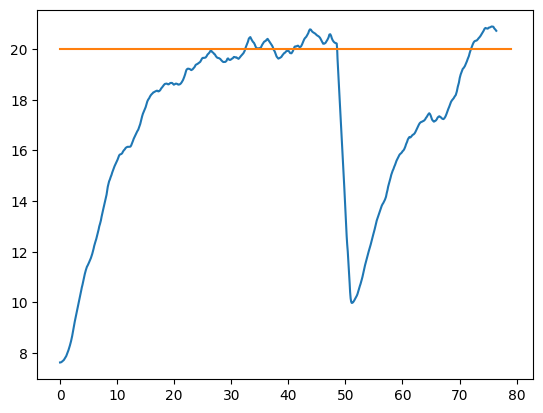

In [36]:
plt.plot(output_X, output_Y)
plt.plot([i for i in range(80)], [20 for _ in range(80)])

In [3]:
import copy
def plot_kwy(trials, win_size, alpha, coarse):
    output_X = []
    output_Y = []
    output_eps = []
    for trial in trials:
        trial_output_X, trial_output_Y, trial_output_eps = generate_keepaway_learning_curves(trial, win_size, alpha, coarse)
        output_X.append(trial_output_X)
        output_Y.append(trial_output_Y)
        output_eps.append(trial_output_eps)

    min_len = len(output_Y[0])
    min_len_idx = 0
    for y_idx in range(len(output_Y)):
        if len(output_Y[y_idx]) < min_len:
            min_len = len(output_Y[y_idx])
            min_len_idx = y_idx
    avg_output_X = output_X[min_len_idx][:min_len]
    avg_output_eps = output_eps[min_len_idx][:min_len]
    for y_idx in range(len(output_Y)):
        output_Y[y_idx] = copy.deepcopy(output_Y[y_idx][:min_len])
    output_Y = np.array(output_Y)
    avg_output_Y = output_Y.mean(axis=0)

    return avg_output_X, avg_output_Y, avg_output_eps

In [41]:
kwy_no_transfer_paths = []
kwy_train_no_transfer_folder_path = os.path.join(config_data['logs_path'], 'keepaway_4v3_p1', 'logs')
for file in os.listdir(kwy_train_no_transfer_folder_path):
    if file.endswith('kwy'):
        kwy_no_transfer_paths.append([os.path.join(kwy_train_no_transfer_folder_path, file)])
kwy_train_no_transfer_folder_path = os.path.join(config_data['logs_path'], 'keepaway_4v3_p2', 'logs')
for file in os.listdir(kwy_train_no_transfer_folder_path):
    if file.endswith('kwy'):
        kwy_no_transfer_paths.append([os.path.join(kwy_train_no_transfer_folder_path, file)])

In [58]:
output_X, output_Y = plot_kwy(kwy_no_transfer_paths, 1000, 0.01, 30)

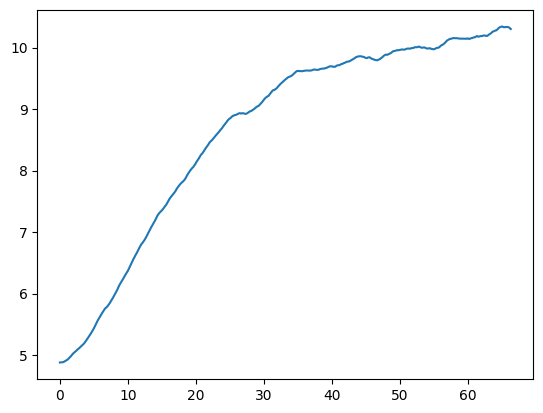

In [59]:
plt.plot(output_X, output_Y, label = 'No transfer')

In [68]:
kwy_handcoded_transfer_paths = []
kwy_handcoded_transfer_folder_path = os.path.join(config_data['logs_path'], '4v3_hand_coded_mapping_results')
for file in os.listdir(kwy_handcoded_transfer_folder_path):
    if file.endswith('kwy'):
        kwy_handcoded_transfer_paths.append([os.path.join(kwy_handcoded_transfer_folder_path, file)])

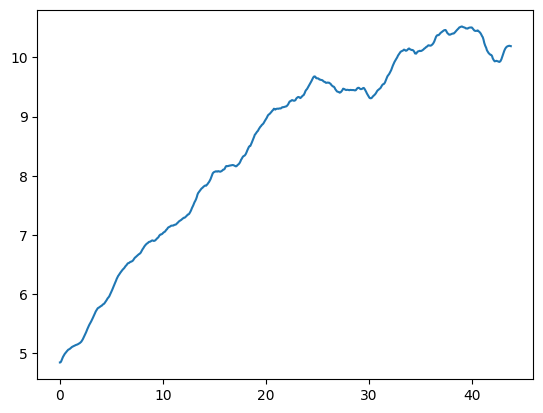

In [69]:
output_X, output_Y = plot_kwy(kwy_handcoded_transfer_paths, 1000, 0.01, 30)
plt.plot(output_X, output_Y, label = 'Hand coded')

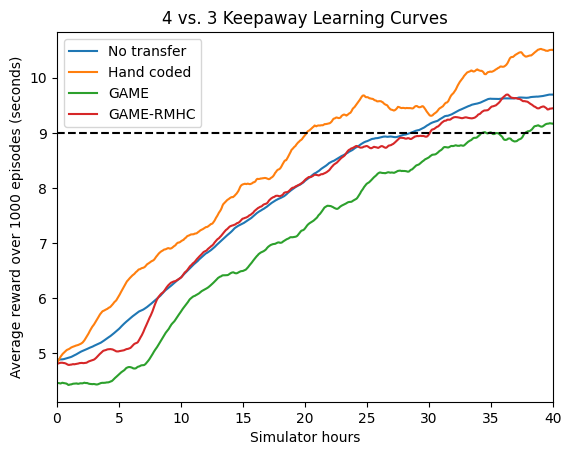

In [42]:
kwy_no_transfer_paths = []
kwy_train_no_transfer_folder_path = os.path.join(config_data['logs_path'], 'keepaway_4v3_p1', 'logs')
for file in os.listdir(kwy_train_no_transfer_folder_path):
    if file.endswith('kwy'):
        kwy_no_transfer_paths.append([os.path.join(kwy_train_no_transfer_folder_path, file)])
kwy_train_no_transfer_folder_path = os.path.join(config_data['logs_path'], 'keepaway_4v3_p2', 'logs')
for file in os.listdir(kwy_train_no_transfer_folder_path):
    if file.endswith('kwy'):
        kwy_no_transfer_paths.append([os.path.join(kwy_train_no_transfer_folder_path, file)])

output_X, output_Y, output_eps = plot_kwy(kwy_no_transfer_paths, 1000, 0.01, 30)
plt.plot(output_X, output_Y, label = 'No transfer')

kwy_handcoded_transfer_paths = []
kwy_handcoded_transfer_folder_path = os.path.join(config_data['logs_path'], '4v3_hand_coded_mapping_results')
for file in os.listdir(kwy_handcoded_transfer_folder_path):
    if file.endswith('kwy'):
        kwy_handcoded_transfer_paths.append([os.path.join(kwy_handcoded_transfer_folder_path, file)])
output_X, output_Y, output_eps = plot_kwy(kwy_handcoded_transfer_paths, 1000, 0.01, 30)
plt.plot(output_X, output_Y, label = 'Hand coded')

kwy_GAME_transfer_paths = []
kwy_GAME_transfer_folder_path = os.path.join(config_data['logs_path'], 'GAME results')
for file in os.listdir(kwy_GAME_transfer_folder_path):
    if file.endswith('kwy'):
        kwy_GAME_transfer_paths.append([os.path.join(kwy_GAME_transfer_folder_path, file)])
output_X, output_Y, output_eps = plot_kwy(kwy_GAME_transfer_paths, 1000, 0.01, 30)
plt.plot(output_X, output_Y, label = 'GAME')

kwy_GAMERMHC_transfer_paths = []
kwy_GAMERMHC_transfer_folder_path = os.path.join(config_data['logs_path'], 'GAME-RMHC results')
for file in os.listdir(kwy_GAMERMHC_transfer_folder_path):
    if file.endswith('kwy'):
        kwy_GAMERMHC_transfer_paths.append([os.path.join(kwy_GAMERMHC_transfer_folder_path, file)])
output_X, output_Y, output_eps = plot_kwy(kwy_GAMERMHC_transfer_paths, 1000, 0.01, 30)
plt.plot(output_X, output_Y, label = 'GAME-RMHC')

plt.plot([0, 40], [9, 9], 'k--')

plt.xlim(0, 40)
plt.xlabel('Simulator hours')
plt.ylabel('Average reward over 1000 episodes (seconds)')
plt.title('4 vs. 3 Keepaway Learning Curves')
plt.legend()

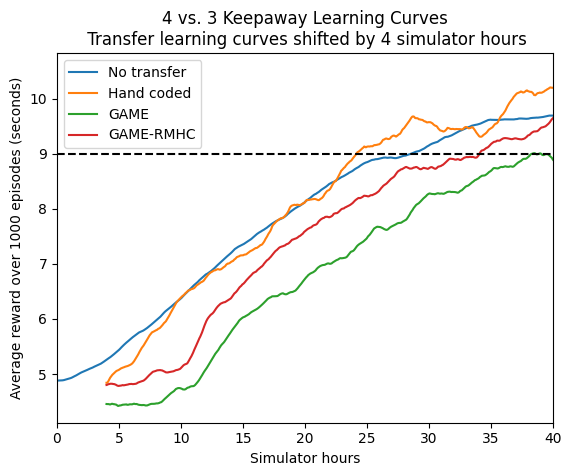

In [41]:
kwy_no_transfer_paths = []
kwy_train_no_transfer_folder_path = os.path.join(config_data['logs_path'], 'keepaway_4v3_p1', 'logs')
for file in os.listdir(kwy_train_no_transfer_folder_path):
    if file.endswith('kwy'):
        kwy_no_transfer_paths.append([os.path.join(kwy_train_no_transfer_folder_path, file)])
kwy_train_no_transfer_folder_path = os.path.join(config_data['logs_path'], 'keepaway_4v3_p2', 'logs')
for file in os.listdir(kwy_train_no_transfer_folder_path):
    if file.endswith('kwy'):
        kwy_no_transfer_paths.append([os.path.join(kwy_train_no_transfer_folder_path, file)])

output_X, output_Y, output_eps = plot_kwy(kwy_no_transfer_paths, 1000, 0.01, 30)
plt.plot(output_X, output_Y, label = 'No transfer')

kwy_handcoded_transfer_paths = []
kwy_handcoded_transfer_folder_path = os.path.join(config_data['logs_path'], '4v3_hand_coded_mapping_results')
for file in os.listdir(kwy_handcoded_transfer_folder_path):
    if file.endswith('kwy'):
        kwy_handcoded_transfer_paths.append([os.path.join(kwy_handcoded_transfer_folder_path, file)])
output_X, output_Y, output_eps = plot_kwy(kwy_handcoded_transfer_paths, 1000, 0.01, 30)
output_X = np.array(output_X) + 4 # or 2000 episodes
plt.plot(output_X, output_Y, label = 'Hand coded')

kwy_GAME_transfer_paths = []
kwy_GAME_transfer_folder_path = os.path.join(config_data['logs_path'], 'GAME results')
for file in os.listdir(kwy_GAME_transfer_folder_path):
    if file.endswith('kwy'):
        kwy_GAME_transfer_paths.append([os.path.join(kwy_GAME_transfer_folder_path, file)])
output_X, output_Y, output_eps = plot_kwy(kwy_GAME_transfer_paths, 1000, 0.01, 30)
output_X = np.array(output_X) + 4 # or 2000 episodes
plt.plot(output_X, output_Y, label = 'GAME')

kwy_GAMERMHC_transfer_paths = []
kwy_GAMERMHC_transfer_folder_path = os.path.join(config_data['logs_path'], 'GAME-RMHC results')
for file in os.listdir(kwy_GAMERMHC_transfer_folder_path):
    if file.endswith('kwy'):
        kwy_GAMERMHC_transfer_paths.append([os.path.join(kwy_GAMERMHC_transfer_folder_path, file)])
output_X, output_Y, output_eps = plot_kwy(kwy_GAMERMHC_transfer_paths, 1000, 0.01, 30)
output_X = np.array(output_X) + 4 # or 2000 episodes
plt.plot(output_X, output_Y, label = 'GAME-RMHC')

plt.plot([0, 40], [9, 9], 'k--')

plt.xlim(0, 40)
plt.xlabel('Simulator hours')
plt.ylabel('Average reward over 1000 episodes (seconds)')
plt.title('4 vs. 3 Keepaway Learning Curves\n Transfer learning curves shifted by 4 simulator hours')
plt.legend()

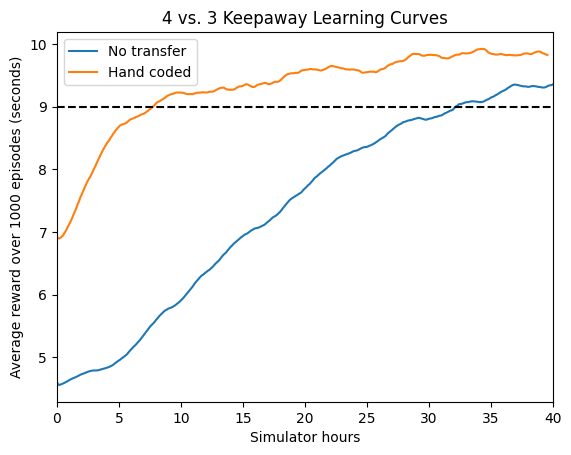

In [4]:
kwy_no_transfer_paths = []
kwy_train_no_transfer_folder_path = os.path.join(config_data['logs_path'], '12282022 no transfer eval')
for file in os.listdir(kwy_train_no_transfer_folder_path):
    if file.endswith('kwy'):
        kwy_no_transfer_paths.append([os.path.join(kwy_train_no_transfer_folder_path, file)])
kwy_train_no_transfer_folder_path = os.path.join(config_data['logs_path'], '12282022 no transfer eval 2')
for file in os.listdir(kwy_train_no_transfer_folder_path):
    if file.endswith('kwy'):
        kwy_no_transfer_paths.append([os.path.join(kwy_train_no_transfer_folder_path, file)])

output_X, output_Y, output_eps = plot_kwy(kwy_no_transfer_paths, 1000, 0.01, 30)
plt.plot(output_X, output_Y, label = 'No transfer')

kwy_handcoded_transfer_paths = []
kwy_handcoded_transfer_folder_path = os.path.join(config_data['logs_path'], '12292022 transfer hand coded eval')
for file in os.listdir(kwy_handcoded_transfer_folder_path):
    if file.endswith('kwy'):
        kwy_handcoded_transfer_paths.append([os.path.join(kwy_handcoded_transfer_folder_path, file)])
kwy_handcoded_transfer_folder_path = os.path.join(config_data['logs_path'], '12292022 transfer hand coded eval 2')
for file in os.listdir(kwy_handcoded_transfer_folder_path):
    if file.endswith('kwy'):
        kwy_handcoded_transfer_paths.append([os.path.join(kwy_handcoded_transfer_folder_path, file)])        
output_X, output_Y, output_eps = plot_kwy(kwy_handcoded_transfer_paths, 1000, 0.01, 30)
plt.plot(output_X, output_Y, label = 'Hand coded')

# kwy_GAME_transfer_paths = []
# kwy_GAME_transfer_folder_path = os.path.join(config_data['logs_path'], 'GAME results')
# for file in os.listdir(kwy_GAME_transfer_folder_path):
#     if file.endswith('kwy'):
#         kwy_GAME_transfer_paths.append([os.path.join(kwy_GAME_transfer_folder_path, file)])
# output_X, output_Y, output_eps = plot_kwy(kwy_GAME_transfer_paths, 1000, 0.01, 30)
# plt.plot(output_X, output_Y, label = 'GAME')

# kwy_GAMERMHC_transfer_paths = []
# kwy_GAMERMHC_transfer_folder_path = os.path.join(config_data['logs_path'], 'GAME-RMHC results')
# for file in os.listdir(kwy_GAMERMHC_transfer_folder_path):
#     if file.endswith('kwy'):
#         kwy_GAMERMHC_transfer_paths.append([os.path.join(kwy_GAMERMHC_transfer_folder_path, file)])
# output_X, output_Y, output_eps = plot_kwy(kwy_GAMERMHC_transfer_paths, 1000, 0.01, 30)
# plt.plot(output_X, output_Y, label = 'GAME-RMHC')

plt.plot([0, 40], [9, 9], 'k--')

plt.xlim(0, 40)
plt.xlabel('Simulator hours')
plt.ylabel('Average reward over 1000 episodes (seconds)')
plt.title('4 vs. 3 Keepaway Learning Curves')
plt.legend()